In [209]:
from __future__ import division, print_function
import time
import torch.utils.data
import torchvision
from torchvision import transforms, datasets
import argparse
import matplotlib
from Bayes_By_Backprop.model import *
from Bayes_By_Backprop_Local_Reparametrization.model import *
import time

matplotlib.use('Agg')
import matplotlib.pyplot as plt

In [210]:
from numpy import genfromtxt
data = genfromtxt('onehot.csv', delimiter=',', skip_header=True)[:,1:]
print('data shape:', data.shape)

data shape: (8124, 118)


In [211]:
# FFNN
import torch.nn.functional as F
import torch

class Net(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size) 
        self.fc3 = torch.nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        return out

In [212]:
# regression BNN
%matplotlib inline
import GPy
import time
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Optimizer

from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange

def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        if not v.is_cuda and cuda:
            v = v.cuda()

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out

def log_gaussian_loss(output, target, sigma, no_dim):
    exponent = -0.5*(target - output)**2/sigma**2
    log_coeff = -no_dim*torch.log(sigma)
    
    return - (log_coeff + exponent).sum()


def get_kl_divergence(weights, prior, varpost):
    prior_loglik = prior.loglik(weights)
    
    varpost_loglik = varpost.loglik(weights)
    varpost_lik = varpost_loglik.exp()
    
    return (varpost_lik*(varpost_loglik - prior_loglik)).sum()


class gaussian:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def loglik(self, weights):
        exponent = -0.5*(weights - self.mu)**2/self.sigma**2
        log_coeff = -0.5*(np.log(2*np.pi) + 2*np.log(self.sigma))
        
        return (exponent + log_coeff).sum()
    
class BayesLinear_Normalq(nn.Module):
    def __init__(self, input_dim, output_dim, prior):
        super(BayesLinear_Normalq, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.prior = prior
        
        scale = (2/self.input_dim)**0.5
        rho_init = np.log(np.exp((2/self.input_dim)**0.5) - 1)
        self.weight_mus = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-0.05, 0.05))
        self.weight_rhos = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-2, -1))
        
        self.bias_mus = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-0.05, 0.05))
        self.bias_rhos = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-2, -1))
        
    def forward(self, x, sample = True):
        
        if sample:
            # sample gaussian noise for each weight and each bias
            weight_epsilons = Variable(self.weight_mus.data.new(self.weight_mus.size()).normal_())
            bias_epsilons =  Variable(self.bias_mus.data.new(self.bias_mus.size()).normal_())
            
            # calculate the weight and bias stds from the rho parameters
            weight_stds = torch.log(1 + torch.exp(self.weight_rhos))
            bias_stds = torch.log(1 + torch.exp(self.bias_rhos))
            
            # calculate samples from the posterior from the sampled noise and mus/stds
            weight_sample = self.weight_mus + weight_epsilons*weight_stds
            bias_sample = self.bias_mus + bias_epsilons*bias_stds
            
            output = torch.mm(x, weight_sample) + bias_sample
            
            # computing the KL loss term
            prior_cov, varpost_cov = self.prior.sigma**2, weight_stds**2
            KL_loss = 0.5*(torch.log(prior_cov/varpost_cov)).sum() - 0.5*weight_stds.numel()
            KL_loss = KL_loss + 0.5*(varpost_cov/prior_cov).sum()
            KL_loss = KL_loss + 0.5*((self.weight_mus - self.prior.mu)**2/prior_cov).sum()
            
            prior_cov, varpost_cov = self.prior.sigma**2, bias_stds**2
            KL_loss = KL_loss + 0.5*(torch.log(prior_cov/varpost_cov)).sum() - 0.5*bias_stds.numel()
            KL_loss = KL_loss + 0.5*(varpost_cov/prior_cov).sum()
            KL_loss = KL_loss + 0.5*((self.bias_mus - self.prior.mu)**2/prior_cov).sum()
            
            return output, KL_loss
        
        else:
            output = torch.mm(x, self.weight_mus) + self.bias_mus
            return output, KL_loss
        
    def sample_layer(self, no_samples):
        all_samples = []
        for i in range(no_samples):
            # sample gaussian noise for each weight and each bias
            weight_epsilons = Variable(self.weight_mus.data.new(self.weight_mus.size()).normal_())
            
            # calculate the weight and bias stds from the rho parameters
            weight_stds = torch.log(1 + torch.exp(self.weight_rhos))
            
            # calculate samples from the posterior from the sampled noise and mus/stds
            weight_sample = self.weight_mus + weight_epsilons*weight_stds
            
            all_samples += weight_sample.view(-1).cpu().data.numpy().tolist()
            
        return all_samples
    
class BBP_Homoscedastic_Model(nn.Module):
    def __init__(self, input_dim, output_dim, no_units, init_log_noise):
        super(BBP_Homoscedastic_Model, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # network with two hidden and one output layer
        self.layer1 = BayesLinear_Normalq(input_dim, no_units, gaussian(0, 1))
        self.layer2 = BayesLinear_Normalq(no_units, output_dim, gaussian(0, 1))
        
        # activation to be used between hidden layers
        self.activation = nn.ReLU(inplace = True)
        self.log_noise = nn.Parameter(torch.cuda.FloatTensor([init_log_noise]))

    
    def forward(self, x):
        
        KL_loss_total = 0
        x = x.view(-1, self.input_dim)
        
        x, KL_loss = self.layer1(x)
        KL_loss_total = KL_loss_total + KL_loss
        x = self.activation(x)
        
        x, KL_loss = self.layer2(x)
        KL_loss_total = KL_loss_total + KL_loss
        
        return x, KL_loss_total
    

class BBP_Homoscedastic_Model_Wrapper:
    def __init__(self, input_dim, output_dim, no_units, learn_rate, batch_size, no_batches, init_log_noise):
        
        self.learn_rate = learn_rate
        self.batch_size = batch_size
        self.no_batches = no_batches
        
        self.network = BBP_Homoscedastic_Model(input_dim = input_dim, output_dim = output_dim,
                                               no_units = no_units, init_log_noise = init_log_noise)
        self.network.cuda()
        
        self.optimizer = torch.optim.SGD(self.network.parameters(), lr = self.learn_rate) 
        # self.optimizer = torch.optim.Adam(self.network.parameters(), lr = self.learn_rate)
        self.loss_func = log_gaussian_loss
    
    def fit(self, x, y, no_samples):
        x, y = to_variable(var=(x, y), cuda=True)
        
        # reset gradient and total loss
        self.optimizer.zero_grad()
        fit_loss_total = 0
        
        for i in range(no_samples):
            output, KL_loss_total = self.network(x)

            # calculate fit loss based on mean and standard deviation of output
            fit_loss_total = fit_loss_total + self.loss_func(output, y, self.network.log_noise.exp(), self.network.output_dim)
        
        KL_loss_total = KL_loss_total/self.no_batches
        total_loss = (fit_loss_total + KL_loss_total)/(no_samples*x.shape[0])
        total_loss.backward()
        self.optimizer.step()

        return fit_loss_total/no_samples, KL_loss_total

In [213]:
# train BNN
t0 = time.time()

bnet = BBP_Homoscedastic_Model_Wrapper(input_dim = 119, output_dim = 1, no_units = 100, learn_rate = 1e-6,
                                      batch_size = 64, no_batches = 1, init_log_noise = 0)

num_episodes=10000
batch_size=64
regret = []
eat = np.array([[1,0] for _ in range(batch_size)])
ignore = np.array([[0,1] for _ in range(batch_size)])

for i in range(num_episodes):
    
    # get 64 mushrooms
    idx = np.random.randint(len(data), size=batch_size)
    data_train = data[idx,:]
    X, poisonous = data_train[:,1:], data_train[:,0]
    
    
    
    # get scores for eating and ignoring
    eat_array = np.append(X, eat, axis=1)
    eat_scores, loss = bnet.network.forward(torch.tensor(eat_array).float().cuda())
    ignore_array = np.append(X, ignore, axis=1)
    ignore_scores, loss = bnet.network.forward(torch.tensor(ignore_array).float().cuda())
    
    x_train, y_train = np.zeros(eat_array.shape), np.zeros(poisonous.shape)
    
    # get training vectors
    diffs = (eat_scores.cpu().detach().numpy() - ignore_scores.cpu().detach().numpy()).reshape((batch_size,))
    x_train[diffs>0] = eat_array[diffs>0] # ate it
    x_train[diffs<=0] = ignore_array[diffs<=0] # ignored it
    
    # get training labels
    vals = np.random.normal(0, 1, batch_size)
    y_train[vals>0] = -35
    y_train[vals<=0] = 5
    y_train[poisonous==0] = 5 # ate it (safe)
    y_train[diffs <= 0] = 0 # if you ignored it

    
    # get regret for this episode
    oracle_score = 5 * sum(poisonous==1) # optimal strategy eats all good and ignores all bad
    agent_score = sum(y_train)
    regret.append(oracle_score - agent_score)
    
    # backprop
    fit_loss, KL_loss = bnet.fit(x_train, y_train, no_samples = batch_size)

    if not i % 100:
        print('iteration:', i, 'regret:', oracle_score - agent_score, 'fit loss:', fit_loss.item(), 'kl loss:', KL_loss.item())
        
print('time elapsed:', time.time() - t0)

iteration: 0 regret: 310.0 fit loss: 430206.71875 kl loss: 13640.7578125
iteration: 100 regret: 165.0 fit loss: 17438.357421875 kl loss: 13640.7685546875
iteration: 200 regret: 705.0 fit loss: 163864.890625 kl loss: 13640.775390625
iteration: 300 regret: 100.0 fit loss: 11838.150390625 kl loss: 13640.779296875
iteration: 400 regret: 150.0 fit loss: 9548.328125 kl loss: 13640.783203125
iteration: 500 regret: 160.0 fit loss: 5436.76220703125 kl loss: 13640.78515625
iteration: 600 regret: 205.0 fit loss: 15260.216796875 kl loss: 13640.78515625
iteration: 700 regret: 225.0 fit loss: 11463.552734375 kl loss: 13640.7861328125
iteration: 800 regret: 530.0 fit loss: 43136.38671875 kl loss: 13640.787109375
iteration: 900 regret: 580.0 fit loss: 38995.3125 kl loss: 13640.7880859375
iteration: 1000 regret: 305.0 fit loss: 16213.818359375 kl loss: 13640.7890625
iteration: 1100 regret: 180.0 fit loss: 14373.173828125 kl loss: 13640.7900390625
iteration: 1200 regret: 315.0 fit loss: 22454.93359375 k

In [214]:
# %matplotlib inline
# from matplotlib import pyplot as plt

# cum_regrets = list(regret)
# for i in range(1, len(cum_regrets)): cum_regrets[i] += cum_regrets[i-1]

# bnn_cum_regrets = cum_regrets
# pickle.dump(bnn_cum_regrets, open('results/bnn_regret.pkl', 'wb'))

# plt.yscale('log')
# plt.plot(bnn_cum_regrets)

In [215]:
# train greedy FNN
np.random.seed(1)
t0 = time.time()

learning_rate = 1e-6
nhid = 100
fnet = Net(119, nhid, 1)
fnet.cuda()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(fnet.parameters(), lr=learning_rate)

num_episodes=10000
batch_size=64
regret = []
eat = np.array([[1,0] for _ in range(batch_size)])
ignore = np.array([[0,1] for _ in range(batch_size)])

for i in range(num_episodes):
    
    # get 64 mushrooms
    idx = np.random.randint(len(data), size=batch_size)
    data_train = data[idx,:]
    X, poisonous = data_train[:,1:], data_train[:,0]
    
    
    
    # get scores for eating and ignoring
    eat_array = np.append(X, eat, axis=1)
    eat_scores = fnet(torch.tensor(eat_array).float().cuda())
    ignore_array = np.append(X, ignore, axis=1)
    ignore_scores = fnet(torch.tensor(ignore_array).float().cuda())
    
    x_train, y_train = np.zeros(eat_array.shape), np.zeros(poisonous.shape)
    
    # get training vectors
    diffs = (eat_scores.cpu().detach().numpy() - ignore_scores.cpu().detach().numpy()).reshape((batch_size,))
    x_train[diffs>0] = eat_array[diffs>0] # ate it
    x_train[diffs<=0] = ignore_array[diffs<=0] # ignored it
    
    # get training labels
    vals = np.random.normal(0, 1, batch_size)
    y_train[vals>0] = -35
    y_train[vals<=0] = 5
    y_train[poisonous==0] = 5 # ate it (safe)
    y_train[diffs <= 0] = 0 # if you ignored it

    
    # get regret for this episode
    oracle_score = 5 * sum(poisonous==1) # optimal strategy eats all good and ignores all bad
    agent_score = sum(y_train)
    regret.append(oracle_score - agent_score)
    
    # backprop
    outputs = eat_scores
    outputs[diffs<=0] = ignore_scores[diffs<=0]
    outputs = outputs.reshape((batch_size,))
    loss = criterion(torch.tensor(outputs).cuda(), torch.tensor(y_train).cuda())
    loss = Variable(loss, requires_grad = True)
    loss.backward()
    optimizer.step()
    
    if not i % 100:
        print('iteration:', i, 'regret:', oracle_score - agent_score, 'fit loss:', fit_loss.item(), 'kl loss:', KL_loss.item())

print('time elapsed:', time.time() - t0)

iteration: 0 regret: 160.0 fit loss: 16785.8515625 kl loss: 13640.810546875
iteration: 100 regret: 235.0 fit loss: 16785.8515625 kl loss: 13640.810546875


 /homes/awl27/testenv/lib/python3.5/site-packages/ipykernel_launcher.py:57: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


iteration: 200 regret: 195.0 fit loss: 16785.8515625 kl loss: 13640.810546875
iteration: 300 regret: 210.0 fit loss: 16785.8515625 kl loss: 13640.810546875
iteration: 400 regret: 205.0 fit loss: 16785.8515625 kl loss: 13640.810546875
iteration: 500 regret: 250.0 fit loss: 16785.8515625 kl loss: 13640.810546875
iteration: 600 regret: 180.0 fit loss: 16785.8515625 kl loss: 13640.810546875
iteration: 700 regret: 220.0 fit loss: 16785.8515625 kl loss: 13640.810546875
iteration: 800 regret: 190.0 fit loss: 16785.8515625 kl loss: 13640.810546875
iteration: 900 regret: 215.0 fit loss: 16785.8515625 kl loss: 13640.810546875
iteration: 1000 regret: 145.0 fit loss: 16785.8515625 kl loss: 13640.810546875
iteration: 1100 regret: 185.0 fit loss: 16785.8515625 kl loss: 13640.810546875
iteration: 1200 regret: 210.0 fit loss: 16785.8515625 kl loss: 13640.810546875
iteration: 1300 regret: 175.0 fit loss: 16785.8515625 kl loss: 13640.810546875
iteration: 1400 regret: 295.0 fit loss: 16785.8515625 kl los

In [216]:
# %matplotlib inline
# from matplotlib import pyplot as plt

# cum_regrets = list(regret)
# for i in range(1, len(cum_regrets)): cum_regrets[i] += cum_regrets[i-1]

# fnn_cum_regrets = cum_regrets

# plt.yscale('log')
# plt.plot(fnn_cum_regrets[1:500], label='greedy')
# plt.plot(bnn_cum_regrets[1:500], label='bnn')
# plt.legend()

In [217]:
# train 1% greedy FNN
t0 = time.time()

#initialize net
fnet = Net(119, nhid, 1)
fnet.cuda()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(fnet.parameters(), lr=learning_rate)

epsilon = 0.01
num_episodes=10000
batch_size=64
regret = []
eat = np.array([[1,0] for _ in range(batch_size)])
ignore = np.array([[0,1] for _ in range(batch_size)])

for i in range(num_episodes):
    
    # get 64 mushrooms
    idx = np.random.randint(len(data), size=batch_size)
    data_train = data[idx,:]
    X, poisonous = data_train[:,1:], data_train[:,0]
    
    # get scores for eating and ignoring
    eat_array = np.append(X, eat, axis=1)
    eat_scores = fnet(torch.tensor(eat_array).float().cuda())
    ignore_array = np.append(X, ignore, axis=1)
    ignore_scores = fnet(torch.tensor(ignore_array).float().cuda())
    
    x_train, y_train = np.zeros(eat_array.shape), np.zeros(poisonous.shape)
    
    # get training vectors
    diffs = (eat_scores.cpu().detach().numpy() - ignore_scores.cpu().detach().numpy()).reshape((batch_size,))
    
    # epsilon greedy behavior change to score differences
    eps = np.random.uniform(0, 1, batch_size) # generate uniform vector
    random_actions = np.random.normal(0, 1, batch_size)
    random_actions[random_actions>0] = 1
    random_actions[random_actions<=0] = -1
    diffs[eps > 1 - epsilon] = random_actions[eps > 1 - epsilon]
    
    x_train[diffs>0] = eat_array[diffs>0] # ate it
    x_train[diffs<=0] = ignore_array[diffs<=0] # ignored it
    
    # get training labels
    vals = np.random.normal(0, 1, batch_size)
    y_train[vals>0] = -35
    y_train[vals<=0] = 5
    y_train[poisonous==0] = 5 # ate it (safe)
    y_train[diffs <= 0] = 0 # if you ignored it

    
    # get regret for this episode
    oracle_score = 5 * sum(poisonous==1) # optimal strategy eats all good and ignores all bad
    agent_score = sum(y_train)
    regret.append(oracle_score - agent_score)
    
    # backprop
    outputs = eat_scores
    outputs[diffs<=0] = ignore_scores[diffs<=0]
    outputs = outputs.reshape((batch_size,))
    loss = criterion(torch.tensor(outputs).cuda(), torch.tensor(y_train).cuda())
    loss = Variable(loss, requires_grad = True)
    loss.backward()
    optimizer.step()
    
    if not i % 100:
        print('iteration:', i, 'regret:', oracle_score - agent_score, 'fit loss:', fit_loss.item(), 'kl loss:', KL_loss.item())

print('time elapsed:', time.time() - t0)

iteration: 0 regret: 140.0 fit loss: 16785.8515625 kl loss: 13640.810546875


 /homes/awl27/testenv/lib/python3.5/site-packages/ipykernel_launcher.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


iteration: 100 regret: 510.0 fit loss: 16785.8515625 kl loss: 13640.810546875
iteration: 200 regret: 375.0 fit loss: 16785.8515625 kl loss: 13640.810546875
iteration: 300 regret: 685.0 fit loss: 16785.8515625 kl loss: 13640.810546875
iteration: 400 regret: 340.0 fit loss: 16785.8515625 kl loss: 13640.810546875
iteration: 500 regret: 640.0 fit loss: 16785.8515625 kl loss: 13640.810546875
iteration: 600 regret: 530.0 fit loss: 16785.8515625 kl loss: 13640.810546875
iteration: 700 regret: 595.0 fit loss: 16785.8515625 kl loss: 13640.810546875
iteration: 800 regret: 245.0 fit loss: 16785.8515625 kl loss: 13640.810546875
iteration: 900 regret: 655.0 fit loss: 16785.8515625 kl loss: 13640.810546875
iteration: 1000 regret: 580.0 fit loss: 16785.8515625 kl loss: 13640.810546875
iteration: 1100 regret: 590.0 fit loss: 16785.8515625 kl loss: 13640.810546875
iteration: 1200 regret: 450.0 fit loss: 16785.8515625 kl loss: 13640.810546875
iteration: 1300 regret: 645.0 fit loss: 16785.8515625 kl loss

In [218]:
# %matplotlib inline
# from matplotlib import pyplot as plt

# cum_regrets = list(regret)
# for i in range(1, len(cum_regrets)): cum_regrets[i] += cum_regrets[i-1]

# fnn_cum_regrets1 = cum_regrets

# plt.yscale('log')
# plt.plot(fnn_cum_regrets[1:500], label='greedy')
# plt.plot(bnn_cum_regrets[1:500], label='bnn')
# plt.plot(fnn_cum_regrets5[1:500], label='1% greedy')
# plt.legend()

In [219]:
# train 5% greedy FNN
t0 = time.time()

#initialize net
fnet = Net(119, nhid, 1)
fnet.cuda()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(fnet.parameters(), lr=learning_rate)

epsilon = 0.05
num_episodes=10000
batch_size=64
regret = []
eat = np.array([[1,0] for _ in range(batch_size)])
ignore = np.array([[0,1] for _ in range(batch_size)])

for i in range(num_episodes):
    
    # get 64 mushrooms
    idx = np.random.randint(len(data), size=batch_size)
    data_train = data[idx,:]
    X, poisonous = data_train[:,1:], data_train[:,0]
    
    # get scores for eating and ignoring
    eat_array = np.append(X, eat, axis=1)
    eat_scores = fnet(torch.tensor(eat_array).float().cuda())
    ignore_array = np.append(X, ignore, axis=1)
    ignore_scores = fnet(torch.tensor(ignore_array).float().cuda())
    
    x_train, y_train = np.zeros(eat_array.shape), np.zeros(poisonous.shape)
    
    # get training vectors
    diffs = (eat_scores.cpu().detach().numpy() - ignore_scores.cpu().detach().numpy()).reshape((batch_size,))
    
    # epsilon greedy behavior change to score differences
    eps = np.random.uniform(0, 1, batch_size) # generate uniform vector
    random_actions = np.random.normal(0, 1, batch_size)
    random_actions[random_actions>0] = 1
    random_actions[random_actions<=0] = -1
    diffs[eps > 1 - epsilon] = random_actions[eps > 1 - epsilon]
    
    x_train[diffs>0] = eat_array[diffs>0] # ate it
    x_train[diffs<=0] = ignore_array[diffs<=0] # ignored it
    
    # get training labels
    vals = np.random.normal(0, 1, batch_size)
    y_train[vals>0] = -35
    y_train[vals<=0] = 5
    y_train[poisonous==0] = 5 # ate it (safe)
    y_train[diffs <= 0] = 0 # if you ignored it

    
    # get regret for this episode
    oracle_score = 5 * sum(poisonous==1) # optimal strategy eats all good and ignores all bad
    agent_score = sum(y_train)
    regret.append(oracle_score - agent_score)
    
    # backprop
    outputs = eat_scores
    outputs[diffs<=0] = ignore_scores[diffs<=0]
    outputs = outputs.reshape((batch_size,))
    loss = criterion(torch.tensor(outputs).cuda(), torch.tensor(y_train).cuda())
    loss = Variable(loss, requires_grad = True)
    loss.backward()
    optimizer.step()
    
    if not i % 100:
        print('iteration:', i, 'regret:', oracle_score - agent_score, 'fit loss:', fit_loss.item(), 'kl loss:', KL_loss.item())

print('time elapsed:', time.time() - t0)

iteration: 0 regret: 485.0 fit loss: 16785.8515625 kl loss: 13640.810546875
iteration: 100 regret: 410.0 fit loss: 16785.8515625 kl loss: 13640.810546875


 /homes/awl27/testenv/lib/python3.5/site-packages/ipykernel_launcher.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


iteration: 200 regret: 380.0 fit loss: 16785.8515625 kl loss: 13640.810546875
iteration: 300 regret: 390.0 fit loss: 16785.8515625 kl loss: 13640.810546875
iteration: 400 regret: 290.0 fit loss: 16785.8515625 kl loss: 13640.810546875
iteration: 500 regret: 240.0 fit loss: 16785.8515625 kl loss: 13640.810546875
iteration: 600 regret: 95.0 fit loss: 16785.8515625 kl loss: 13640.810546875
iteration: 700 regret: 500.0 fit loss: 16785.8515625 kl loss: 13640.810546875
iteration: 800 regret: 345.0 fit loss: 16785.8515625 kl loss: 13640.810546875
iteration: 900 regret: 640.0 fit loss: 16785.8515625 kl loss: 13640.810546875
iteration: 1000 regret: 595.0 fit loss: 16785.8515625 kl loss: 13640.810546875
iteration: 1100 regret: 700.0 fit loss: 16785.8515625 kl loss: 13640.810546875
iteration: 1200 regret: 250.0 fit loss: 16785.8515625 kl loss: 13640.810546875
iteration: 1300 regret: 415.0 fit loss: 16785.8515625 kl loss: 13640.810546875
iteration: 1400 regret: 615.0 fit loss: 16785.8515625 kl loss

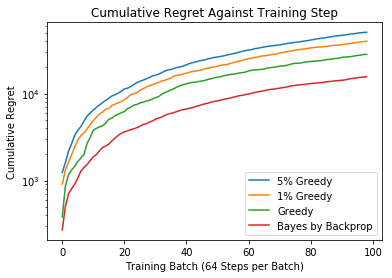

In [19]:
%matplotlib inline
from matplotlib import pyplot as plt
import pickle

# cum_regrets = list(regret)
# for i in range(1, len(cum_regrets)): cum_regrets[i] += cum_regrets[i-1]

# fnn_cum_regrets5 = cum_regrets
# pickle.dump(fnn_cum_regrets, open('results/fnn_regret.pkl', 'wb'))
# pickle.dump(fnn_cum_regrets1, open('results/fnn_regret1.pkl', 'wb'))
# pickle.dump(fnn_cum_regrets5, open('results/fnn_regret5.pkl', 'wb'))
# pickle.dump(bnn_cum_regrets, open('results/bnn_regret.pkl', 'wb'))

fnn_cum_regrets = pickle.load(open('results/fnn_regret.pkl', 'rb'))
fnn_cum_regrets1 = pickle.load(open('results/fnn_regret1.pkl', 'rb'))
fnn_cum_regrets5 = pickle.load(open('results/fnn_regret5.pkl', 'rb'))
bnn_cum_regrets = pickle.load(open('results/bnn_regret.pkl', 'rb'))

plt.yscale('log')
cutoff = 100
plt.plot(fnn_cum_regrets5[1:cutoff], label='5% Greedy')
plt.plot(fnn_cum_regrets1[1:cutoff], label='1% Greedy')
plt.plot(fnn_cum_regrets[1:cutoff], label='Greedy')
plt.plot(bnn_cum_regrets[1:cutoff], label='Bayes by Backprop')

plt.title('Cumulative Regret Against Training Step')
plt.ylabel('Cumulative Regret')
plt.xlabel('Training Batch (64 Steps per Batch)')

plt.legend()